# AutoEncoders on Fashion MNIST

**The notebook has been adapted from the notebook provided in David Foster's Generative Deep Learning, 2nd Edition.**

- Book: [Amazon](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184/ref=sr_1_1?keywords=generative+deep+learning%2C+2nd+edition&qid=1684708209&sprefix=generative+de%2Caps%2C93&sr=8-1)
- Original notebook (tensorflow and keras): [Github](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/03_vae/01_autoencoder/autoencoder.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

import jax
import jax.numpy as jnp

from flax import linen as nn
from flax.training import train_state
import optax

## 0. Train parameters

In [2]:
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 128
EMBEDDING_DIM = 2
EPOCHS = 10
LEARNING_RATE = 1e-3

## 1. Prepare dataset

In [3]:
# Process the image file
def preprocess(img):
    img = tf.cast(img, tf.float32) / 255.
    img = tf.pad(img, ((2, 2), (2, 2), (0, 0)), constant_values=0)
    return img

# get MNIST dataset
def get_dataset(num_epochs, batch_size):
    # Download MNIST dataset
    train_ds = tfds.load('fashion_mnist', split='train')
    test_ds = tfds.load('fashion_mnist', split='test')

    # Mapping images as tf tensors
    train_ds = train_ds.map(lambda sample: {'image': preprocess(sample['image']),
                                            'label': sample['label']})
    test_ds = test_ds.map(lambda sample: {'image': preprocess(sample['image']),
                                          'label': sample['label']})

    # TF dataloader
    train_ds = train_ds.repeat(num_epochs).shuffle(1024)
    train_ds = train_ds.batch(batch_size, drop_remainder=True).prefetch(1)
    test_ds = test_ds.shuffle(1024)
    test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1)

    return train_ds, test_ds

In [4]:
check_train, check_test = get_dataset(EPOCHS, BATCH_SIZE)
print(next(iter(check_train))['image'].shape)

(128, 32, 32, 1)


## 2. Build the AutoEncoder

In [5]:
# Encoder
class Encoder(nn.Module):
    latents: int
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3), strides=2)(x)
        x = nn.relu(x)
        x = nn.Conv(features=64, kernel_size=(3, 3), strides=2)(x)
        x = nn.relu(x)
        x = nn.Conv(features=128, kernel_size=(3, 3), strides=2)(x)
        x = nn.relu(x)
        x = x.reshape(x.shape[0], -1)
        x = nn.Dense(features=self.latents)(x)
        return x

# Decoder
class Decoder(nn.Module):

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=2048)(x)
        x = x.reshape(x.shape[0], 4, 4, 128)
        x = nn.ConvTranspose(features=128, kernel_size=(3, 3), strides=(2, 2))(x)
        x = nn.relu(x)
        x = nn.ConvTranspose(features=64, kernel_size=(3, 3), strides=(2, 2))(x)
        x = nn.relu(x)
        x = nn.ConvTranspose(features=32, kernel_size=(3, 3), strides=(2, 2))(x)
        x = nn.relu(x)
        x = nn.Conv(features=1, kernel_size=(3, 3), strides=1)(x)
        return x

In [6]:
# AutoEncoder
class AE(nn.Module):
    latents: int
    
    def setup(self):
        self.encoder = Encoder(self.latents)
        self.decoder = Decoder()

    def __call__(self, x):
        z = self.encoder(x)
        recon_x = self.decoder(z)
        return recon_x

    def generate(self, z):
        return nn.sigmoid(self.decoder(z))

ae = AE(EMBEDDING_DIM)
print(ae.tabulate(jax.random.PRNGKey(0), jnp.ones((1, 32, 32, 1)), console_kwargs={'width': 110}))


                                                  AE Summary                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path                  ┃ module        ┃ inputs              ┃ outputs             ┃ params                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│                       │ AE            │ float32[1,32,32,1]  │ float32[1,32,32,1]  │                        │
├───────────────────────┼───────────────┼─────────────────────┼─────────────────────┼────────────────────────┤
│ encoder               │ Encoder       │ float32[1,32,32,1]  │ float32[1,2]        │                        │
├───────────────────────┼───────────────┼─────────────────────┼─────────────────────┼────────────────────────┤
│ encoder/Conv_0        │ Conv          │ float32[1,32,32,1]  │ float32[1,16,16,32] │ bias: float32[32]      │


### Loss function

In [7]:
@jax.vmap
def binary_cross_entropy_with_logits(logits, labels):
    logits = nn.log_sigmoid(logits)
    return -jnp.sum(labels * logits + (1. - labels) * jnp.log(-jnp.expm1(logits)))

## 3. Creating a `TrainState`

In [8]:
def create_train_state(model, rng, learning_rate):
    # Initialize the model
    params = model.init(rng, jnp.ones([1, 32, 32, 1]))['params']
    # Initialize the optimizer
    tx = optax.adam(LEARNING_RATE)
    return train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=tx
    )

## 4. Train step

In [9]:
@jax.jit
def train_step(state, batch):
    def loss_fn(params):
        recon_x = state.apply_fn({'params': params}, batch['image'])
        loss = binary_cross_entropy_with_logits(recon_x, batch['image']).mean()
        return loss
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state

In [10]:
@jax.jit
def compute_metrics(*, state, batch):
    recon_x = state.apply_fn({'params': state.params}, batch['image'])
    loss = binary_cross_entropy_with_logits(recon_x, batch['image']).mean()
    return loss, recon_x

## 5. Load dataset and initialize the model

In [11]:
train_ds, test_ds = get_dataset(EPOCHS, BATCH_SIZE)

tf.random.set_seed(0)
rng = jax.random.PRNGKey(0)

ae = AE(EMBEDDING_DIM)
state = create_train_state(ae, rng, LEARNING_RATE)

## 6. Train and evaluate

In [12]:
num_steps_per_epoch = train_ds.cardinality().numpy() // EPOCHS

metrics_history = {
    'train_loss': [],
    'test_loss': []
}

In [13]:
train_loss_hist = []
test_loss_hist = []

for step, batch in enumerate(train_ds.as_numpy_iterator()):
    rng, key = jax.random.split(rng)

    state = train_step(state, batch)
    train_loss, _ = compute_metrics(state=state, batch=batch)
    train_loss_hist.append(train_loss)
    
    if (step + 1) % num_steps_per_epoch == 0:
        metrics_history['train_loss'].append(np.mean(train_loss_hist) /  BATCH_SIZE)
        train_loss_hist = []
        
        for test_batch in test_ds.as_numpy_iterator():
            test_loss, recon_x = compute_metrics(state=state, batch=test_batch)
            test_loss_hist.append(test_loss)

        metrics_history['test_loss'].append(np.mean(test_loss_hist) / BATCH_SIZE)
        test_loss_hist = []

        print('Epoch {}:'.format((step + 1) // num_steps_per_epoch))
        print(f'\tTrain - loss: {metrics_history["train_loss"][-1]:.4f}')
        print(f'\tTest - loss: {metrics_history["test_loss"][-1]:.4f}')

Epoch 1:
	Train - loss: 2.3152
	Test - loss: 2.1336
Epoch 2:
	Train - loss: 2.0857
	Test - loss: 2.0778
Epoch 3:
	Train - loss: 2.0449
	Test - loss: 2.0483
Epoch 4:
	Train - loss: 2.0192
	Test - loss: 2.0292
Epoch 5:
	Train - loss: 2.0053
	Test - loss: 2.0246
Epoch 6:
	Train - loss: 1.9948
	Test - loss: 2.0106
Epoch 7:
	Train - loss: 1.9859
	Test - loss: 2.0059
Epoch 8:
	Train - loss: 1.9784
	Test - loss: 2.0029
Epoch 9:
	Train - loss: 1.9733
	Test - loss: 1.9982
Epoch 10:
	Train - loss: 1.9674
	Test - loss: 1.9986


## 7. Embed using `Encoder`

In [14]:
@jax.jit
def encode_imgs(params, images):
    def get_embeddings(ae):
        z = ae.encoder(images)
        return z

    ae = AE(EMBEDDING_DIM)
    return nn.apply(get_embeddings, ae)({'params': params})

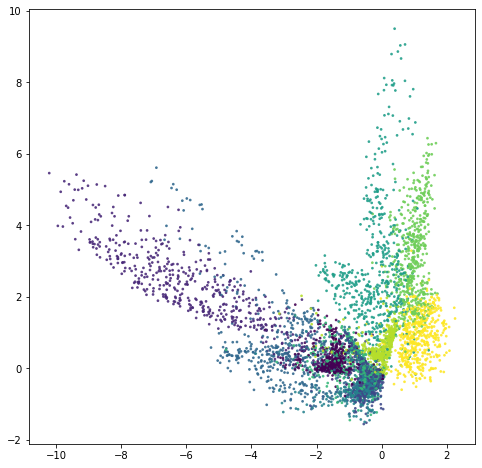

In [15]:
num_samples = 5000
num_iters = np.ceil(num_samples / BATCH_SIZE).astype(int)

test_loader = test_ds.as_numpy_iterator()

for i in range(num_iters):
    batch = next(iter(test_loader))
    embeddings = encode_imgs(state.params, batch['image'])
    if i == 0:
        output_embs = embeddings
        output_labels = batch['label']
    else:
        output_embs = np.concatenate([output_embs, embeddings])
        output_labels = np.concatenate([output_labels, batch['label']])

plt.figure(figsize=(8, 8))
plt.scatter(output_embs[:, 0], 
            output_embs[:, 1], 
            c=output_labels, 
            alpha=0.8,
            s=3)
plt.show()

## 8. Generate using `Decoder`

In [16]:
@jax.jit
def generate_imgs(params, samples):
    def decode_embs(ae):
        imgs = ae.generate(samples)
        return imgs
    ae = AE(EMBEDDING_DIM)
    return nn.apply(decode_embs, ae)({'params': params})

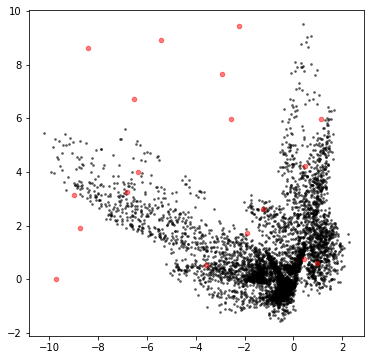

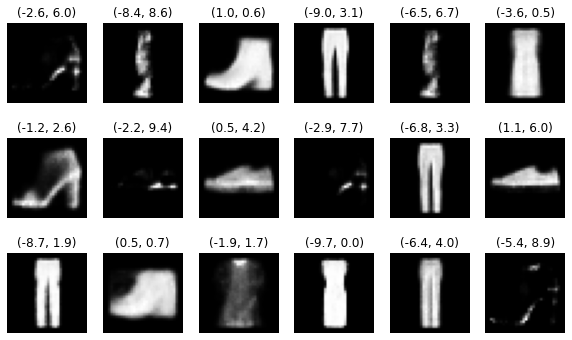

In [17]:
# Sampling from the embedding space
x_min, x_max = output_embs[:, 0].min(), output_embs[:, 0].max()
y_min, y_max = output_embs[:, 1].min(), output_embs[:, 1].max()

xs = np.random.uniform(x_min, x_max, size=(18, 1))
ys = np.random.uniform(y_min, y_max, size=(18, 1))
samples = np.hstack([xs, ys])

output_imgs = generate_imgs(state.params, samples)

plt.figure(figsize=(6, 6))
plt.scatter(output_embs[:, 0], 
            output_embs[:, 1], 
            c='black', 
            alpha=0.5,
            s=3)
plt.scatter(samples[:, 0], 
            samples[:, 1], 
            c='red', 
            alpha=0.5,
            s=20)
plt.show()

# Generate new images from sampled embeddings
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(10, 6))
for i in range(output_imgs.shape[0]):
    curr_row = i // 6
    curr_col = i % 6
    ax = axes[curr_row, curr_col]
    
    ax.set_title(f'({samples[i][0]:.1f}, {samples[i][1]:.1f})')
    ax.axis('off')
    ax.imshow(output_imgs[i], cmap='gray')

plt.show()